In [1]:
%matplotlib widget
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

Populating the interactive namespace from numpy and matplotlib


In [2]:
import argparse
import os
import pickle
import pandas as pd
import numpy as np
import torch

import pyro
import pyro.infer
import pyro.infer.mcmc
import pyro.distributions as dist

import os

import matplotlib.pyplot as plt
import seaborn as sns

os.environ['KMP_DUPLICATE_LIB_OK']='True'

Let's generate data for 18 models, 1000 examples, with a, b, theta, gamma, parameters.
a, b, theta are multiple dimensions.

## Lets define prior distribution

In [3]:
def set_seeds(seed):
    np.random.seed(seed)
    pyro.set_rng_seed(seed)
    torch.manual_seed(seed)

def sigmoid(x):
    return 1.0 / (1.0 + torch.exp(-x))

In [4]:
seed=42
diff="normal"
discr="lognormal"
guess="normal"
ability="normal"

diff_transform="identity"
discr_transform="identity"
guess_transform="identity"
ability_transform="identity"

alpha_std=1
item_param_std=1
dimension=3


dist_type="multivariate"

In [5]:
set_seeds(seed)

# defining dataset sizes
n_models, n_items = 20, 3000
dimension=3
stdev = 10
mean_scale = 1

# Fix params for alpha and gamma

Let's fix alpha and gamma to be easier.

In [6]:
gamma = torch.ones(n_items) * 0 #np.finfo(float).eps
alphas = torch.ones(n_items, dimension) * 1.5e-1

In [7]:
beta_mean = 40*mean_scale

beta_0 = dist.Normal(torch.tensor([beta_mean, -0.5*beta_mean, -0.5*beta_mean])*torch.ones(n_items//3, 1), stdev).sample()
beta_1 = dist.Normal(torch.tensor([-0.5*beta_mean, beta_mean, -0.5*beta_mean])*torch.ones(n_items//3, 1), stdev).sample()
beta_2 = dist.Normal(torch.tensor([-0.5*beta_mean, -0.5*beta_mean, beta_mean])*torch.ones(n_items//3, 1), stdev).sample()

In [8]:
betas = torch.vstack([beta_0, beta_1, beta_2])


In [9]:
thetas = dist.Normal(torch.zeros(n_models, dimension), stdev).sample()
thetas.size()

torch.Size([20, 3])

In [10]:

if dimension > 1:
    probs = gamma[None, :]  + (1.0 - gamma[None, :])   * sigmoid( 1./np.sqrt(dimension) * torch.sum(alphas[None, :, :] * (thetas[:, None] - betas[None, :]).squeeze(), dim=-1))
else:
    probs = gamma[None, :] + (1.0 - gamma[None, :]) * sigmoid(alphas[None, :] * (thetas[:, None] - betas[None, :]))
lik = dist.Bernoulli(probs).sample()

lik.size()


torch.Size([20, 3000])

In [11]:
n_models=lik.size(0)
lik = dist.Bernoulli(probs).sample()
(lik.sum(0)/n_models == 1).sum()

tensor(12)

In [12]:
import torch.nn.functional as F
print(f'0.5 baseline {F.mse_loss(0.5*torch.ones(probs.shape), probs)}')
print(f'0 baseline {F.mse_loss(0*torch.ones(probs.shape), probs)}')
print(f'1 baseline {F.mse_loss(1*torch.ones(probs.shape), probs)}')
print(f'mean baseline {F.mse_loss(probs.mean()*torch.ones(probs.shape), probs)}')

0.5 baseline 0.10782348364591599
0 baseline 0.3764054477214813
1 baseline 0.33924153447151184
mean baseline 0.10747818648815155


(array([ 8954.,  5803.,  4955.,  4331.,  4343.,  4531.,  4681.,  5379.,
         6617., 10406.]),
 array([1.52920635e-04, 1.00126676e-01, 2.00100422e-01, 3.00074190e-01,
        4.00047928e-01, 5.00021696e-01, 5.99995434e-01, 6.99969172e-01,
        7.99942970e-01, 8.99916708e-01, 9.99890447e-01], dtype=float32),
 <a list of 10 Patch objects>)

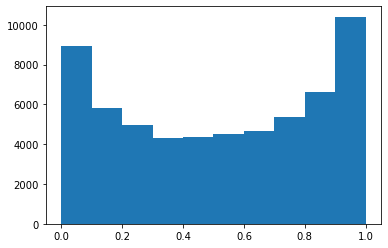

In [13]:
f = plt.figure()
plt.hist(probs.reshape(-1,))

C:\Users\Willi\Anaconda3\envs\DL\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


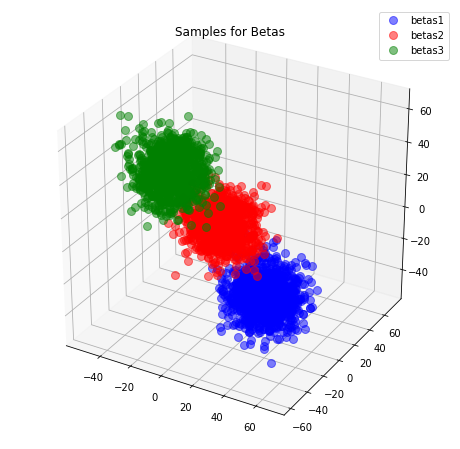

In [14]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(betas.T[0,:1000], betas.T[1,:1000], betas.T[2,:1000], 'o', markersize=8, color='blue', alpha=0.5, label='betas1')
ax.plot(betas.T[0,1000:2000], betas.T[1,1000:2000], betas.T[2,1000:2000], 'o', markersize=8, color='red', alpha=0.5, label='betas2')
ax.plot(betas.T[0,2000:], betas.T[1,2000:], betas.T[2,2000:], 'o', markersize=8, color='green', alpha=0.5, label='betas3')

plt.title('Samples for Betas')
ax.legend(loc='upper right')

plt.show()

C:\Users\Willi\Anaconda3\envs\DL\lib\site-packages\mpl_toolkits\mplot3d\proj3d.py:189: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array([xs, ys, zs, np.ones_like(xs)])


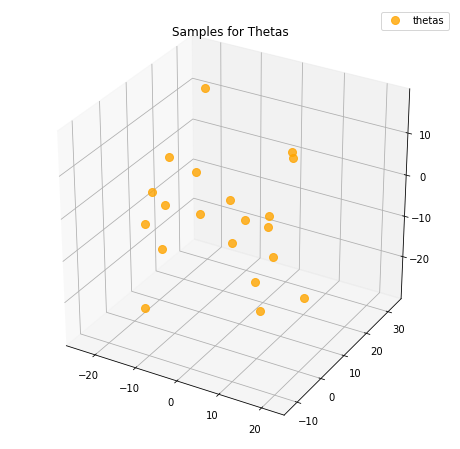

In [15]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(thetas.T[0,:], thetas.T[1,:], thetas.T[2,:], 'o', markersize=8, color='orange', alpha=0.8, label='thetas')
# ax.plot(thetas.T[0,:10], thetas.T[1,:10], thetas.T[2,:10], 'o', markersize=8, color='blue', alpha=0.5, label='thetas1')
# ax.plot(thetas.T[0,10:20], thetas.T[1,10:20], thetas.T[2,10:20], '^', markersize=8, color='red', alpha=0.5, label='thetas2')
# ax.plot(thetas.T[0,10:15], thetas.T[1,10:15], thetas.T[2,10:15], 'x', markersize=8, color='green', alpha=0.5, label='thetas3')
# ax.plot(thetas.T[0,15:20], thetas.T[1,15:20], thetas.T[2,15:20], '+', markersize=8, color='orange', alpha=0.8, label='thetas4')
#ax.plot(thetas.T[0,12:15], thetas.T[1,12:15], thetas.T[2,12:15], '^', markersize=8, color='cyan', alpha=0.5, label='thetas4')
#ax.plot(thetas.T[0,15:18], thetas.T[1,15:18], thetas.T[2,15:18], '^', markersize=8, color='black', alpha=0.5, label='thetas5')
plt.title('Samples for Thetas')
ax.legend(loc='upper right')

plt.show()

In [16]:

model_names = ["model_{}".format(i) for i in range(n_models)]
items_names = [f"data_fix-ac_d{dimension}_diffskills" for i in range(n_items)]

df = pd.DataFrame(data=lik.numpy().astype(int),
                  index=model_names,
                  columns=items_names)
df.index.names = ['userid']

param_dict = {
        "a": alphas.numpy(),
        "b": betas.numpy(),
        "g": gamma.numpy(),
        "t": thetas.numpy(),
        "probs": probs.numpy()
}


In [17]:
response_dir=os.path.join('..','data_synthetic', 'diff_skills')
os.makedirs(response_dir, exist_ok=True)

In [18]:
with open(os.path.join(response_dir, f'params_varied_sync_dim{dimension}_diffskills_irt_all_coded.p'), 'wb') as handle:
    pickle.dump(param_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

response_output=os.path.join(response_dir, f'sync_varied_dim{dimension}_diffskills_irt_all_coded.csv')
df.to_csv(response_output)
   

In [19]:
df

,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,...,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills,data_fix-ac_d3_diffskills
userid,,,,,,,,,,,,,,,,,,,,,
model_0,0,1,1,1,0,0,0,0,0,0,...,1,0,1,1,1,0,0,1,1,1
model_1,0,1,1,1,1,0,1,0,0,1,...,1,1,0,0,1,1,0,1,1,1
model_2,0,1,1,0,1,0,1,0,0,0,...,1,0,1,0,0,1,0,0,0,1
model_3,0,1,1,1,1,0,1,0,0,1,...,1,1,1,0,1,1,0,1,1,1
model_4,0,1,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
model_5,0,1,1,1,1,0,1,0,0,0,...,1,1,0,1,1,1,0,1,1,1
model_6,0,1,1,1,1,0,0,0,0,0,...,1,1,0,1,1,1,0,1,1,1
model_7,0,1,1,0,1,0,1,1,0,1,...,1,1,0,0,1,1,0,1,0,1
model_8,0,1,1,1,1,0,1,1,0,0,...,1,1,1,1,1,0,0,1,1,1


In [20]:
all0s = []
all1s = []
for cname, col in df.items():
    pcent_0 = col.eq(0).sum()/col.shape[0]
    pcent_1 = col.eq(1).sum()/col.shape[0]
    
    if pcent_0 == 1:
        all0s.append(cname)
    elif pcent_1 == 1:
        all1s.append(cname)
        
print(f'All 0s {len(all0s)}')
print(f'All 1s {len(all1s)}')

All 0s 16
All 1s 12
